## PRÁCTICA MODELOS GENERATIVOS
### Usando el conjunto de datos FashionMNIST

En esta celda cargamos las librerías necesarias para el entrenamiento de redes neuronales (torch), el manejo de datos (torchvision) y la visualización de resultados (matplotlib, numpy). También configuramos los hiperparámetros principales.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Configuración y Hiperparámetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
LATENT_DIM = 30  # Tamaño del vector z (espacio latente)
NUM_CLASSES = 10 # Categorías de FashionMNIST
EPOCHS = 20

print(f"Trabajando con el dispositivo: {device}")

Trabajando con el dispositivo: cpu


Cargamos el conjunto de datos FashionMNIST, que consiste en imágenes de 28x28 píxeles de ropa. Aplicamos una transformación para convertir las imágenes en tensores de PyTorch y preparamos los DataLoaders para iterar sobre los datos de entrenamiento y test.

In [49]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Aquí definimos la clase CVAE (Conditional Variational Autoencoder). Este modelo recibe la etiqueta de clase tanto en el Encoder como en el Decoder.
* Encoder: Comprime la imagen y su etiqueta en dos vectores (mu y logvar) que definen una distribución normal en el espacio latente.
* Decoder: Toma un punto del espacio latente (z) y la etiqueta deseada para reconstruir la imagen específica.

In [50]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: Imagen (1x28x28) + Condición
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1 + 1, 32, kernel_size=3, stride=2, padding=1), # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder: Latente (z) + Etiqueta
        self.dec_fc = nn.Linear(latent_dim + num_classes, 64 * 7 * 7)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # Concatenamos la condición como un canal extra de información
        c_channel = torch.argmax(c, dim=1).view(-1, 1, 1, 1).expand(-1, 1, 28, 28).float() / 9.0 
        x_cond = torch.cat([x, c_channel], dim=1) 
        h = self.enc_conv(x_cond)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        h = self.dec_fc(z_cond).view(-1, 64, 7, 7)
        return self.dec_conv(h)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [51]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = CVAE(LATENT_DIM, NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        labels_oh = F.one_hot(labels, num_classes=NUM_CLASSES).float().to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_oh)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f"Epoch {epoch} - Pérdida Promedio: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1 - Pérdida Promedio: 292.3719
Epoch 2 - Pérdida Promedio: 253.3326
Epoch 3 - Pérdida Promedio: 248.4882
Epoch 4 - Pérdida Promedio: 246.2553
Epoch 5 - Pérdida Promedio: 244.7819
Epoch 6 - Pérdida Promedio: 243.6864
Epoch 7 - Pérdida Promedio: 242.7758
Epoch 8 - Pérdida Promedio: 242.0106
Epoch 9 - Pérdida Promedio: 241.3921
Epoch 10 - Pérdida Promedio: 240.8807
Epoch 11 - Pérdida Promedio: 240.3118
Epoch 12 - Pérdida Promedio: 239.8891
Epoch 13 - Pérdida Promedio: 239.5068
Epoch 14 - Pérdida Promedio: 239.1931
Epoch 15 - Pérdida Promedio: 238.9195
Epoch 16 - Pérdida Promedio: 238.6344
Epoch 17 - Pérdida Promedio: 238.4046
Epoch 18 - Pérdida Promedio: 238.1953
Epoch 19 - Pérdida Promedio: 237.9619
Epoch 20 - Pérdida Promedio: 237.8233


Esta celda cumple con el requisito de la práctica: generar 10 muestras aleatorias para cada una de las 10 categorías del dataset. Esto demuestra que el modelo es capaz de "dibujar" una prenda específica basada únicamente en su etiqueta y un vector de ruido latente.

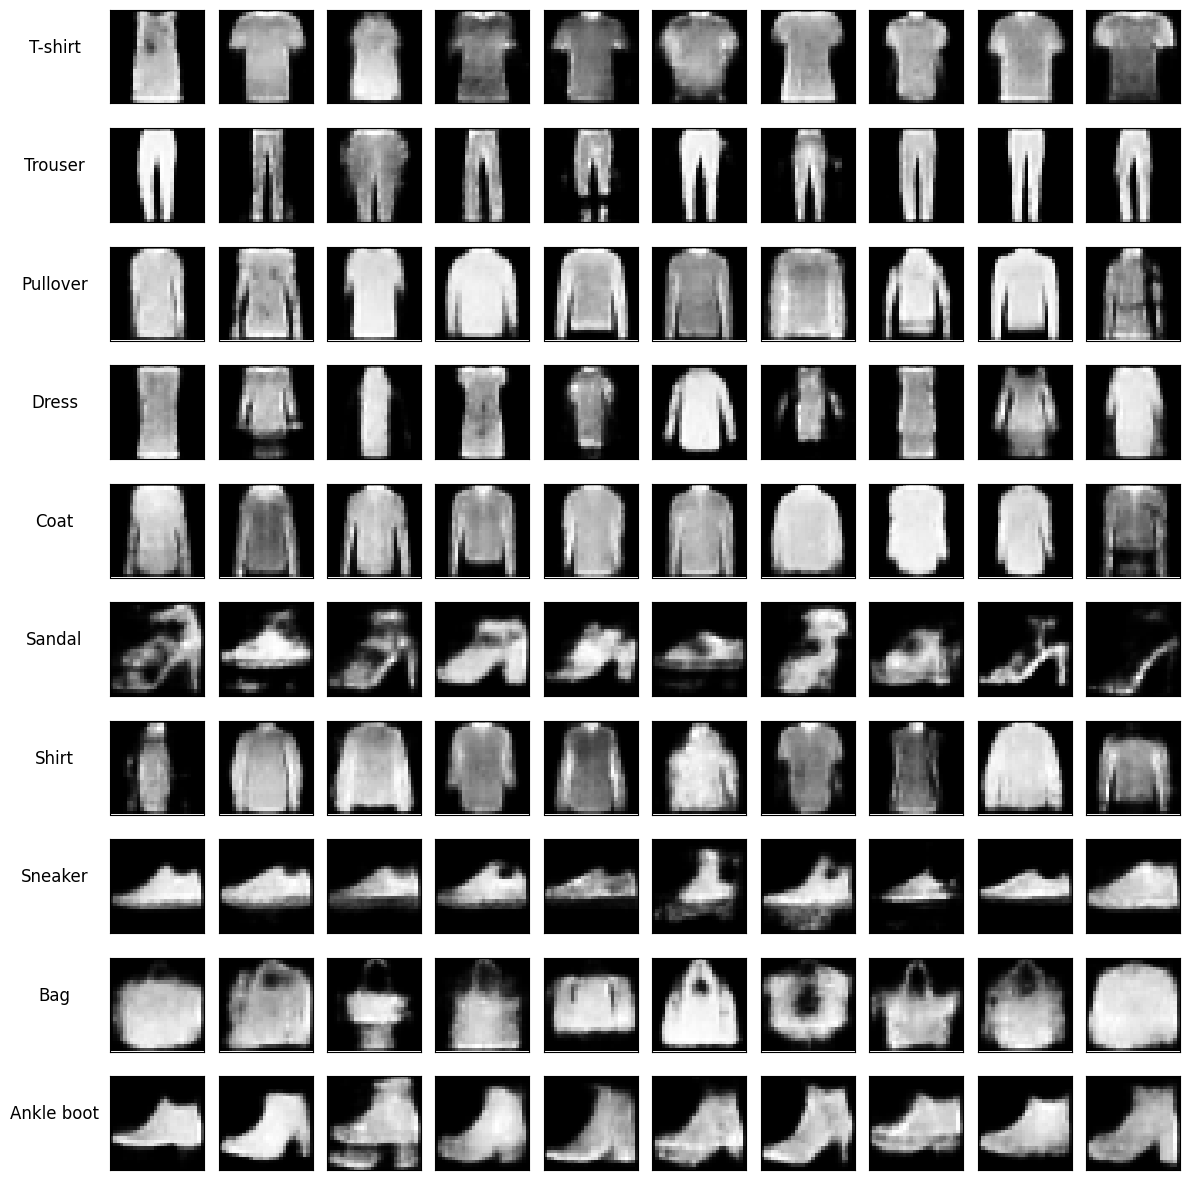

In [52]:
def generate_images(model, n_samples=10):
    model.eval()
    etiquetas_nombres = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    fig, axes = plt.subplots(10, n_samples, figsize=(12, 12))
    
    with torch.no_grad():
        for i in range(10): 
            label = torch.zeros(n_samples, 10).to(device)
            label[:, i] = 1
            z = torch.randn(n_samples, LATENT_DIM).to(device)
            samples = model.decode(z, label).cpu()
            
            axes[i, 0].set_ylabel(etiquetas_nombres[i], rotation=0, labelpad=40, fontsize=12)
            for j in range(n_samples):
                axes[i, j].imshow(samples[j].squeeze(), cmap='gray')
                axes[i, j].set_xticks([]); axes[i, j].set_yticks([])
    plt.tight_layout()
    plt.show()

generate_images(model)

Para demostrar la eficacia del diseño, utilizamos t-SNE para proyectar el espacio latente de 20 dimensiones a 2D. Esto permite visualizar cómo el modelo agrupa prendas similares. Además, realizamos una interpolación lineal, que muestra la transición suave entre dos diseños diferentes de la misma prenda, confirmando que el espacio latente tiene una estructura lógica.

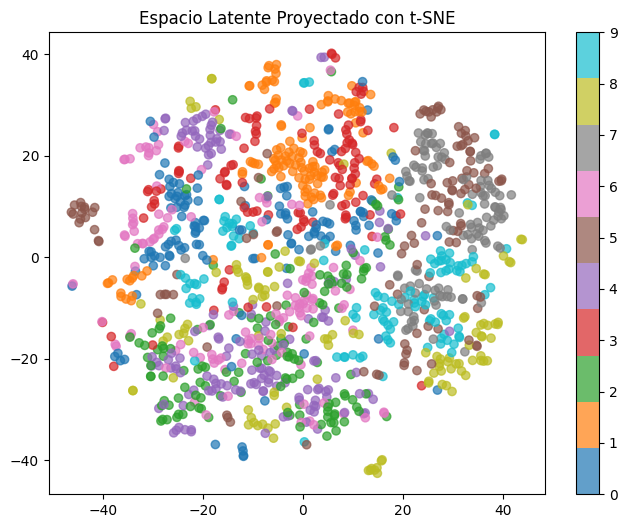

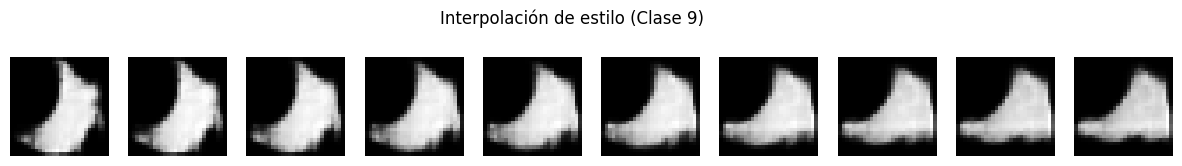

In [53]:
def visualizar_analisis(model, loader):
    model.eval()
    latents, labels_list = [], []
    with torch.no_grad():
        for i, (data, labels) in enumerate(loader):
            if i >= 10: break
            labels_oh = F.one_hot(labels, num_classes=NUM_CLASSES).float().to(device)
            mu, _ = model.encode(data.to(device), labels_oh)
            latents.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())
            
    latents = np.concatenate(latents, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    latents_2d = TSNE(n_components=2, random_state=42).fit_transform(latents)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Espacio Latente Proyectado con t-SNE")
    plt.show()

def mostrar_interpolacion(model, clase_idx=3):
    model.eval()
    z1, z2 = torch.randn(1, LATENT_DIM).to(device), torch.randn(1, LATENT_DIM).to(device)
    c = torch.zeros(1, 10).to(device); c[0, clase_idx] = 1
    alpha = torch.linspace(0, 1, 10).to(device)
    
    plt.figure(figsize=(15, 2))
    for i in range(10):
        z_interp = z1 * (1 - alpha[i]) + z2 * alpha[i]
        muestra = model.decode(z_interp, c).cpu().squeeze()
        plt.subplot(1, 10, i+1)
        plt.imshow(muestra.detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Interpolación de estilo (Clase {clase_idx})")
    plt.show()

visualizar_analisis(model, test_loader)
mostrar_interpolacion(model, clase_idx=9) # Ejemplo con Botines

# Visualizaciones adicionales

### Visualización del mapa de calor de atributos ###
Esta técnica consiste en tomar una imagen real, codificarla en el espacio latente y luego variar una sola dimensión del vector $z$ a la vez. Esto permite descubrir qué "característica" ha aprendido cada dimensión (por ejemplo: una dimensión podría controlar el largo de las mangas, otra el grosor del calzado, etc.).

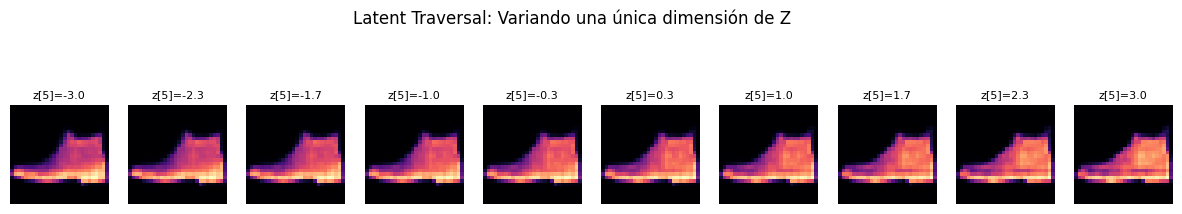

In [54]:
def latent_traversal(model, loader, dimension_to_vary=0, n_steps=10):
    
    model.eval()
    with torch.no_grad():
        # Tomamos una imagen real y su etiqueta
        data, labels = next(iter(loader))
        data, labels = data.to(device), labels.to(device)
        labels_oh = F.one_hot(labels, num_classes=NUM_CLASSES).float()
        
        # Obtenemos su representación latente mu
        mu, _ = model.encode(data, labels_oh)
        z_base = mu[0:1] # Usamos la primera imagen del batch
        c_base = labels_oh[0:1]
        
        # Creamos variaciones en la dimensión elegida (de -3 a 3 desviaciones estándar)
        sways = torch.linspace(-3, 3, n_steps).to(device)
        
        fig, axes = plt.subplots(1, n_steps, figsize=(15, 3))
        for i, val in enumerate(sways):
            z_mod = z_base.clone()
            z_mod[0, dimension_to_vary] = val # Modificamos solo una dimensión
            
            muestra = model.decode(z_mod, c_base).cpu().squeeze()
            axes[i].imshow(muestra, cmap='magma')
            axes[i].axis('off')
            axes[i].set_title(f"z[{dimension_to_vary}]={val:.1f}", fontsize=8)
            
        plt.suptitle("Latent Traversal: Variando una única dimensión de Z")
        plt.show()

# Probar con la dimensión 5 (puedes probar de 0 a LATENT_DIM-1)
latent_traversal(model, test_loader, dimension_to_vary=5)

### Reconstrucción de Imágenes Reales vs. Originales ###
Un CVAE no solo genera, también debe ser capaz de reconstruir. Esta visualización es crucial para evaluar la "fidelidad" del modelo. Ponemos frente a frente la imagen real del dataset de test y la versión que el modelo es capaz de recrear tras pasar por el cuello de botella latente.

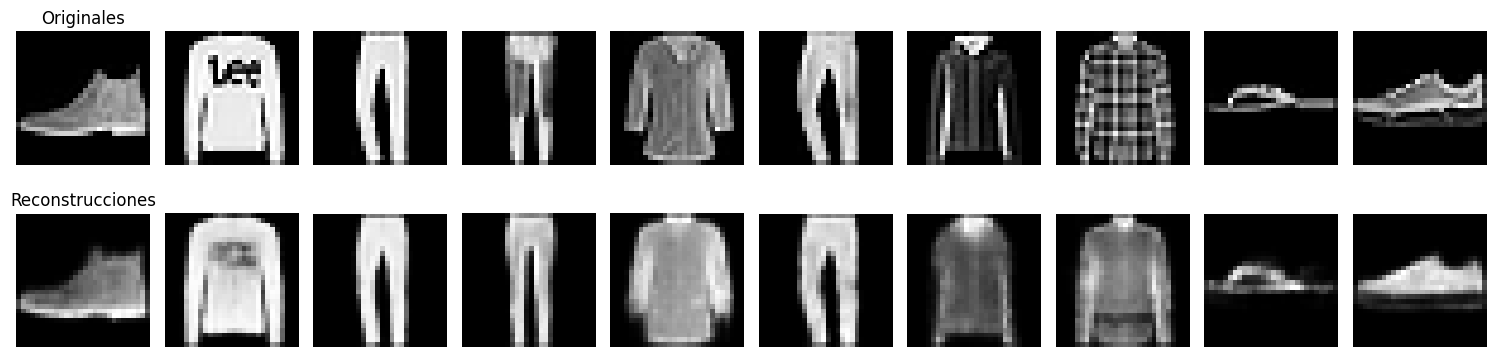

In [55]:
def visualizar_reconstruccion(model, loader, n_images=10):
    """
    Compara imágenes originales del test set con su reconstrucción por el modelo.
    """
    model.eval()
    data, labels = next(iter(loader))
    labels_oh = F.one_hot(labels, num_classes=NUM_CLASSES).float().to(device)
    
    with torch.no_grad():
        recon, mu, _ = model(data.to(device), labels_oh)
        
    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        # Originales
        axes[0, i].imshow(data[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Originales")
        
        # Reconstrucciones
        axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Reconstrucciones")
        
    plt.tight_layout()
    plt.show()

visualizar_reconstruccion(model, test_loader)

### Matriz de Confusión Visual ###
En lugar de interpolar estilos de la misma prenda, aquí interpolamos entre categorías. Por ejemplo, ¿cómo se ve la transformación gradual de una "Zapatilla" (clase 7) a un "Botín" (clase 9)? Esto demuestra que el condicionamiento del modelo es suave y no discreto.

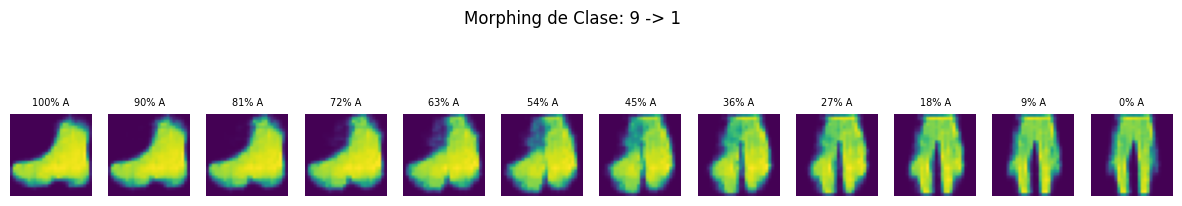

In [71]:
def morphing_entre_clases(model, clase_a=7, clase_b=9, n_steps=12):
    """
    Muestra la transición suave entre dos tipos de prendas distintas.
    """
    model.eval()
    z = torch.randn(1, LATENT_DIM).to(device) # Un mismo estilo
    
    # Creamos un vector que interpola entre el One-Hot de A y el de B
    c_a = F.one_hot(torch.tensor([clase_a]), 10).float().to(device)
    c_b = F.one_hot(torch.tensor([clase_b]), 10).float().to(device)
    
    alphas = torch.linspace(0, 1, n_steps).to(device)
    
    plt.figure(figsize=(15, 3))
    for i, alpha in enumerate(alphas):
        c_interp = c_a * (1 - alpha) + c_b * alpha
        with torch.no_grad():
            muestra = model.decode(z, c_interp).cpu().squeeze()
            
        plt.subplot(1, n_steps, i+1)
        plt.imshow(muestra, cmap='viridis')
        plt.axis('off')
        plt.title(f"{int((1-alpha)*100)}% A", fontsize=7)
        
    plt.suptitle(f"Morphing de Clase: {clase_a} -> {clase_b}")
    plt.show()

# Morphing de Botín (9) a Pantalones (1)
morphing_entre_clases(model, clase_a=9, clase_b=1)